# Extending the SIR model with Branching Processes

January 18, 2023

#### Table of contents:

* [I. Methods](#methods)
    * [I.1. Simulating outbreaks](#methods1)
        * [Transition matrix](#methods1-transition)
        * [Simulations](#methods1-simulations)
        * [Plotting the simulated outbreaks](#methods1-plotting-simulations)
    * [I.2. Studying extinction through simulations and analytically](#methods2)
        * [Counter of the number of extinguished simulations at a given generation](#methods2-counter)
        * [Probability of extinction given by the offspring pgf](#methods2-pgf)
        * [Plotting the number of extinguished simulations against time](#methods2-plotting-extinguished)
    * [I.3. Performing the first simulations and observations](#methods3)
        * [First simulations](#methods3-simulations)
        * [Calculating some first examples of probabilities of extinction](#methods3-examples-prob)
        * [Plotting the number of extinguished simulations against time](#methods3-plotting-extinguished)
* [II. Results](#results)
    * [Probability that an epidemic remains minor or becomes large-scale](#results-large-scale)
        * [Spread of the outbreak in the case of a lockdown](#results-lockdown)
    * [Low-contact _versus_ high-contact _patient zero_](#results-patient-zero)
        * [How long can low-contact individuals remain shielded after an outbreak begins among high-contact individuals?](#results-low-contact-shielded)
        * [Simulating the case of a nursing home](#results-nursing-home)


In [297]:
import random
import matplotlib.pyplot as plt
import numpy
import plotly.graph_objects as go
import plotly.express as px
from sympy import solve, Symbol, sqrt,re
from scipy.integrate import odeint

# I. Methods <a class="anchor" id="methods"></a>

In this section we implement the framework (models and tools) used to yield results. We simulate outbreaks as a Markov chain and as a two-type Branching Process, as described in the written report. Afterwards, we construct tools to count the number of extinguished simulations at a given generation, and to plot the number of extinguished simulations against time. We also implement a tool to calculate the analytical probability of extinction as it is described in the main report, in order to compare this analytical probability to the exctinction phenomena observed in the simulations.

We perform the first simulations and observations, mainly as a way to test the developed framework, and to obtain some preliminary results.

Now, the timestep is the average time in which 1 individual recovers, so g=1. This will make transform b to b/g, so that we have unscaled parameters, for better interpretation. This should be kept in mind for the interpretation. The values of B should now be most interesting around 1.

## I.1. Simulating outbreaks <a class="anchor" id="methods1"></a>


We simulate outbreaks using the two-type branching process approach.

### Transition matrix <a class="anchor" id="methods1-transition"></a>

In [298]:
def W_Markov(S1, I1, S2, I2, SS1, II1, SS2, II2, N, p, B):    
    B = numpy.array(B)/N
    
    # SS is S', II is I'
    
    if S1 == SS1-1 and I1 == II1+1:    # infection type 1
        return (B[0][0]*II1 + B[1][0]*II2)*SS1/N
    elif S2 == SS2-1 and I2 == II2+1:    # infection type 2
        return (B[1][1]*II2 + B[0][1]*II1)*SS2/N
    elif S1 == SS1 and I1 == II1-1:   # recovery type 1
        return II1/N
    elif S2 == SS2 and I2 == II2-1:   # recovery type 2
        return II2/N
    elif S1 == SS1 and I1 == II1 and S2 == SS2 and I2 == II2:     # no change
        return 1 - ((B[0][0]*II1 + B[1][0]*II2)*SS1/N) - ((B[1][1]*II2 + B[0][1]*II1)*SS2/N) - II1/N - II2/N
    else:
        return 0

In [299]:
def W_BP(S1, I1, S2, I2, SS1, II1, SS2, II2, N, p, B):
    B = numpy.array(B)/N
    
    # SS is S', II is I'
    
    if S1 == SS1-1 and I1 == II1+1:    # infection type 1
        return (B[0][0]*II1 + B[1][0]*II2)*p
    elif S2 == SS2-1 and I2 == II2+1:    # infection type 2
        return (B[1][1]*II2 + B[0][1]*II1)*(1-p)
    elif S1 == SS1 and I1 == II1-1:   # recovery type 1
        return II1/N
    elif S2 == SS2 and I2 == II2-1:   # recovery type 2
        return II2/N
    elif S1 == SS1 and I1 == II1 and S2 == SS2 and I2 == II2:     # no change
        return 1 - ((B[0][0]*II1 + B[1][0]*II2)*p) - ((B[1][1]*II2 + B[0][1]*II1)*(1-p)) - II1/N - II2/N
    else:
        return 0

### Simulations <a class="anchor" id="methods1-simulations"></a>

In [300]:
# Functions for stochastic simulation

def simulate_outbreak_Markov(p, B, N, initial_I1, initial_I2, num_simulations, num_generations):
    
    initial_S1 = p*N - initial_I1
    initial_S2 = (1-p)*N - initial_I2
    
    simulations = []
    
    for i in range(num_simulations):
        S1 = initial_S1
        S2 = initial_S2
        I1 = initial_I1
        I2 = initial_I2
        states_S1 = [S1]
        states_I1 = [I1]
        states_S2 = [S2]
        states_I2 = [I2]

        for j in range(num_generations):
            probability_change = {
                'infection1':W_Markov(S1-1,I1+1, S2, I2, S1, I1, S2, I2, N, p, B),
                'infection2':W_Markov(S1, I1, S2-1,I2+1, S1, I1, S2, I2, N, p, B),
                'recovery1':W_Markov(S1, I1-1, S2, I2, S1, I1, S2, I2, N, p, B),
                'recovery2':W_Markov(S1, I1, S2, I2-1, S1, I1, S2, I2, N, p, B),
                'no_change':W_Markov(S1, I1, S2, I2, S1, I1, S2, I2, N, p, B)
            }

            random_change = random.choices(list(probability_change.keys()), weights=probability_change.values())[0]

            if random_change == 'infection1':
                S1 = S1-1
                I1 = I1+1
            elif random_change == 'infection2':
                S2 = S2-1
                I2 = I2+1
            elif random_change == 'recovery1':
                I1 = I1-1
            elif random_change == 'recovery2':
                I2 = I2-1

            states_S1.append(S1)
            states_I1.append(I1)
            states_S2.append(S2)
            states_I2.append(I2)

        simulations.append({'S1':states_S1, 'I1':states_I1, 'S2':states_S2, 'I2':states_I2})
    
    return simulations

In [301]:
# Functions for stochastic simulation

def simulate_outbreak_BP(p, B, N, initial_I1, initial_I2, num_simulations, num_generations):
    ### TODO: get rid of S1 and S2 in this function
    
    initial_S1 = p*N - initial_I1
    initial_S2 = (1-p)*N - initial_I2
    
    simulations = []
    
    for i in range(num_simulations):
        S1 = initial_S1
        S2 = initial_S2
        I1 = initial_I1
        I2 = initial_I2
        states_S1 = [S1]
        states_I1 = [I1]
        states_S2 = [S2]
        states_I2 = [I2]

        for j in range(num_generations):
            probability_change = {
                'infection1':W_BP(S1-1,I1+1, S2, I2, S1, I1, S2, I2, N, p, B),
                'infection2':W_BP(S1, I1, S2-1,I2+1, S1, I1, S2, I2, N, p, B),
                'recovery1':W_BP(S1, I1-1, S2, I2, S1, I1, S2, I2, N, p, B),
                'recovery2':W_BP(S1, I1, S2, I2-1, S1, I1, S2, I2, N, p, B),
                'no_change':W_BP(S1, I1, S2, I2, S1, I1, S2, I2, N, p, B)
            }

            random_change = random.choices(list(probability_change.keys()), weights=probability_change.values())[0]

            if random_change == 'infection1':
                S1 = S1-1
                I1 = I1+1
            elif random_change == 'infection2':
                S2 = S2-1
                I2 = I2+1
            elif random_change == 'recovery1':
                I1 = I1-1
            elif random_change == 'recovery2':
                I2 = I2-1

            states_S1.append(S1)
            states_I1.append(I1)
            states_S2.append(S2)
            states_I2.append(I2)

        simulations.append({'S1':states_S1, 'I1':states_I1, 'S2':states_S2, 'I2':states_I2})
    
    return simulations

### Plotting the simulated outbreaks <a class="anchor" id="methods1-plotting-simulations"></a>

In [302]:
def plot_simulations_I1_I2(simulations, y_bound=None, x_bound=None):
    cmap = plt.get_cmap('hsv')   # adds color to curves in plot
    
    num_generations = len(simulations[0]['I1'])
    average_I1 = [0]*num_generations
    average_I2 = [0]*num_generations
    
    for i in range(len(simulations)):
        # plot susceptible and infected population at each generation
        color = cmap(float(i)/len(simulations))
        plt.plot(range(len(simulations[i]['I1'])),simulations[i]['I1'], color=color, alpha=0.7)
        plt.plot(range(len(simulations[i]['I2'])),simulations[i]['I2'], color=color, linestyle='dashed', alpha=0.7)
        
        for j in range(num_generations):
            average_I1[j] += simulations[i]['I1'][j]
            average_I2[j] += simulations[i]['I2'][j]
            
    average_I1 = [average_I1[k]/len(simulations) for k in range(num_generations)]
    average_I2 = [average_I2[k]/len(simulations) for k in range(num_generations)]
    plt.plot(range(len(average_I1)), average_I1, label='average $I_1$', color='black', linewidth=5)
    plt.plot(range(len(average_I2)), average_I2, label='average $I_2$', color='black', linewidth=5, linestyle='dashed')
    
    plt.legend(prop={'size':14})
    plt.xlabel('generations', fontsize=14)
    plt.ylabel('$I_1, I_2$', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if y_bound is not None:
        plt.ylim(0,y_bound)
    if x_bound is not None:
        plt.xlim(0,x_bound)
    
    
def plot_simulations_I(simulations, y_bound=None, x_bound=None):    
    cmap = plt.get_cmap('hsv')   # adds color to curves in plot
    
    num_generations = len(simulations[0]['I1'])
    average_I = [0]*num_generations
    
    for i in range(len(simulations)):
        states_I = []
        
        for j in range(num_generations):
            states_I.append(simulations[i]['I1'][j] + simulations[i]['I2'][j])
            average_I[j] += simulations[i]['I1'][j] + simulations[i]['I2'][j]
        
        # plot susceptible and infected population at each generation
        color = cmap(float(i)/len(simulations))
        plt.plot(range(len(states_I)),states_I, color=color, linewidth=0.75, alpha=0.7)
        
    average_I = [average_I[k]/len(simulations) for k in range(num_generations)]
    plt.plot(range(len(average_I)), average_I, label='average $I$', color='black', linewidth=5)
    
    plt.legend(prop={'size':14})
    plt.tick_params(labelright=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('generations',fontsize=14)
    plt.ylabel('$I$', fontsize=14)
    if y_bound is not None:
        plt.ylim(0,y_bound)
    if x_bound is not None:
        plt.xlim(0,x_bound)

## I.2. Studying extinction through simulations and analytically <a class="anchor" id="methods2"></a>

### Counter of the number of extinguished simulations at a given generation <a class="anchor" id="methods2-counter"></a>

In [303]:
def extinguished_simulations_at_generation(simulations, generation, print_result=True):
    counter_extinguished = 0
    
    for simulation in simulations:
        if simulation['I1'][generation] == 0 and simulation['I2'][generation] == 0:
            counter_extinguished += 1
                        
    if print_result:
        print('Number of infections extinguished at generation {}: {}'.format(generation,counter_extinguished))
        print('\tProportion: {}'.format(counter_extinguished/len(simulations)))
    else:
        return counter_extinguished/len(simulations)

### Probability of extinction given by the offspring pgf <a class="anchor" id="methods2-pgf"></a>

For this model, the fixed points of the offspring pgf are obtained numerically.

In [304]:
def calculate_lambda(p, B, N=None):
    if N is None:
      N=1
    B = numpy.array(B)/N
    
    return (1/2)*(sqrt(p**2*B[0][0]**2 + 2*p*(1-p)*(2*B[0][1]*B[1][0]-B[0][0]*B[1][1])+(1-p)**2*B[1][1]**2) + p*B[0][0] + (1-p)*B[1][1])+1-1/N

In [305]:
def calculate_probability_extinction(p, B, I1_0, I2_0, N=None):
    # finds the analytical probability of extinction numerically
    Lambda = calculate_lambda(p, B, N=N)
    
    if N is None:
      N=1
        
    B = numpy.array(B)/N   
    
    if Lambda <= 1:
        return 1
    else:
        # solve using sympy solver. Get all solutions, to later make sure
        # that there is only one solution between 0 and 1
        z1,z2 = Symbol('z1'), Symbol('z2')
        eq1 = 1/N + (1-1/N-p*B[0][0]-(1-p)*B[0][1])*z1 + (1-p)*B[0][1]*z1*z2 + p*B[0][0]*z1**2 - z1
        eq2 = 1/N + (1-1/N-p*B[1][0]-(1-p)*B[1][1])*z2 + p*B[1][0]*z1*z2 + (1-p)*B[1][1]*z2**2 - z2  
        imaginary_solutions = solve((eq1,eq2),(z1,z2), dict=True)
        
        # sympy sometimes gives imaginary solutions with imaginary part 
        # very close to zero. Convert solutions to reals.
        real_solutions = []
        for sol in imaginary_solutions:
            real_solutions.append({'z1':float(re(sol[z1])), 'z2':float(re(sol[z2]))})
            
        # Make sure there is only one solution between 0 and 1. Return it.
        fixed_points_between_0_1 = []
        for sol in real_solutions:
            if sol['z1'] > 0.0 and sol['z1'] < 1.0 and sol['z2'] > 0.0 and sol['z2'] < 1.0:
                fixed_points_between_0_1.append((sol['z1'],sol['z2']))
        
        # if there is more than one fixed point between 0 and 1, line above 
        # will raise an error. Otherwise, use unique solution bewteen 0 and 1
        # and return probability of extinction
        u1 = fixed_points_between_0_1[0][0]
        u2 = fixed_points_between_0_1[0][1]
        return u1**I1_0 * u2**I2_0

### Plotting the number of extinguished simulations against time <a class="anchor" id="methods2-plotting-extinguished"></a>

In [306]:
def plot_extinguished_simulations_per_time(simulations,analytical_probability_extinction=None, label_proportion=None, label_probability=None, y_bound=None, x_bound=None):
    num_generations = len(simulations[0]['S1'])
    extinguished_I = [0]*num_generations

    for i in range(len(simulations)):
        for j in range(num_generations):
            extinguished_I[j] = extinguished_I[j] + int(simulations[i]['I1'][j]==0 and simulations[i]['I2'][j]==0)
    
    extinguished_I = numpy.array(extinguished_I)/len(simulations)
    plt.plot(range(len(extinguished_I)),extinguished_I, label=label_proportion)
        
    if analytical_probability_extinction is not None:
        plt.plot(range(len(extinguished_I)),[analytical_probability_extinction]*len(extinguished_I), linestyle='dashed', label=label_probability)
        
    plt.xlabel('Generations', fontsize=14)
    plt.ylabel('Proportion', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(prop={'size':12})
    
    if y_bound is not None:
        plt.ylim(0,y_bound)
    if x_bound is not None:
        plt.xlim(0,x_bound)

## I.3. Performing the first simulations and observations <a class="anchor" id="methods3"></a>

### First simulations <a class="anchor" id="methods3-simulations"></a> 

In [307]:
%matplotlib inline

In [308]:
simulations_BP = simulate_outbreak_BP(
    p=0.1, 
    B=[[0.7, 1],
       [1, 5]],
    N=1000, 
    initial_I1=0,
    initial_I2=1,
    num_simulations=100, 
    num_generations=1500, 
)

In [309]:
extinguished_simulations_at_generation(simulations_BP,generation=1500)

Number of infections extinguished at generation 1500: 23
	Proportion: 0.23


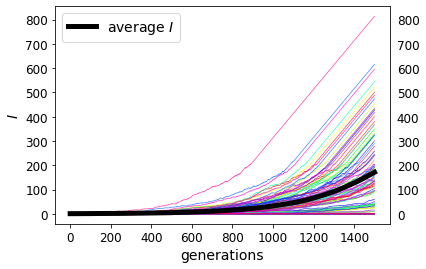

In [310]:
plot_simulations_I(simulations_BP)

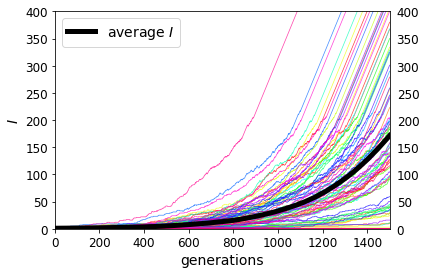

In [311]:
plot_simulations_I(simulations_BP, y_bound=400,x_bound = 1500)

### Calculating some first examples of probabilities of extinction <a class="anchor" id="methods3-examples-prob"></a>

In [312]:
calculate_lambda(p=0.1, B=[[0.7, 1],[1, 5]], N=1000)

1.00352022370245

In [313]:
calculate_probability_extinction(p=0.1, B=[[0.7, 1],[1, 5]], I1_0 = 0, I2_0 = 1, N=1000)

0.21957980487353712

In [314]:
calculate_lambda(p=0.1, B=[[0.1,0.25],[0.25,1]], N=1000)

0.999906275968782

In [315]:
calculate_probability_extinction(p=0.4, B=[[0.05/0.4,0.1/0.4],[0.1/0.4,0.3/0.4]], I1_0=1, I2_0=0, N=1000)

1

### Plotting the number of extinguished simulations against time <a class="anchor" id="methods3-plotting-extinguished"></a>

In [316]:
%matplotlib notebook
# This will enable interacting with the plots (especially zooming)

In [317]:
%matplotlib inline

In [318]:
# Patient zero of type 1
simulations1 = simulate_outbreak_BP(
    p=0.1, 
    B=[[0.7, 1],
       [1, 5]],
    N=1000, 
    initial_I1=1,
    initial_I2=0,
    num_simulations=1000, 
    num_generations=2000, 
)

analytical_probability_extinction1 = calculate_probability_extinction(
    p=0.1, 
    B=[[0.7, 1],
       [1, 5]],
    I1_0=1,
    I2_0=0,
    N=1000
)

# Patient zero of type 2
simulations2 = simulate_outbreak_BP(
    p=0.1, 
    B=[[0.7, 1],
       [1, 5]],
    N=1000,
    initial_I1=0,
    initial_I2=1,
    num_simulations=1000, 
    num_generations=2000
)

analytical_probability_extinction2 = calculate_probability_extinction(
    p=0.1, 
    B=[[0.7, 1],
       [1, 5]],
    I1_0=0,
    I2_0=1,
    N=1000
)

Patient zero 1: 0.5773800150584688
Patient zero 2: 0.21957980487353712


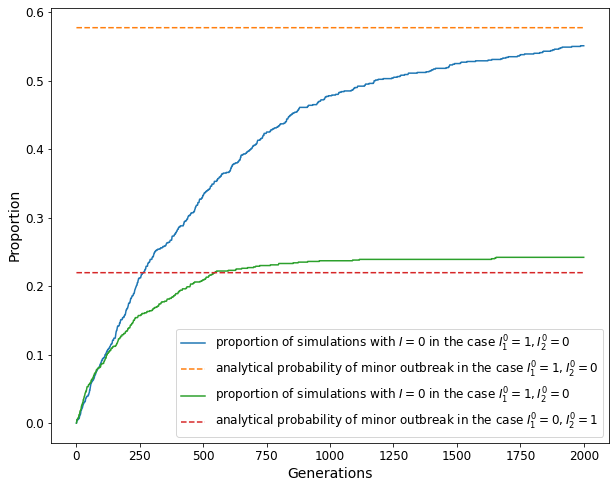

In [319]:
print('Patient zero 1:',analytical_probability_extinction1)
print('Patient zero 2:',analytical_probability_extinction2)


plt.figure(figsize=(10,8))
plot_extinguished_simulations_per_time(simulations1,analytical_probability_extinction1, 
                                       label_proportion='proportion of simulations with $I=0$ in the case $I_1^0=1, I_2^0=0$', 
                                       label_probability='analytical probability of minor outbreak in the case $I_1^0=1, I_2^0=0$')
plot_extinguished_simulations_per_time(simulations2,analytical_probability_extinction2, 
                                       label_proportion='proportion of simulations with $I=0$ in the case $I_1^0=1, I_2^0=0$', 
                                       label_probability='analytical probability of minor outbreak in the case $I_1^0=0, I_2^0=1$')

# II. Results <a class="anchor" id="results"></a>

### Probability that an epidemic remains minor or becomes large-scale <a class="anchor" id="results-large-scale"></a>

We first study the analytical probability of extinction (which approximates the probability of an outbreak remaining minor) and its dependence on the parameters $p, B,$ and on the initial infectious population.

To study this dependence, we plot the probability of extinction over one of the parameters, while fixing the rest.

In [320]:
# Fix the parameters

p=0.1
B=[[0.7, 1],
   [1, 5]]
b = 1
I1_0 = 0
I2_0 = 1
N=1000

In [321]:
%matplotlib inline

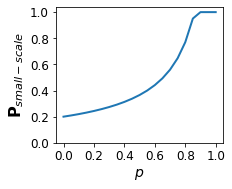

In [322]:
fig = plt.figure(figsize=(3,2.5))


# Probability over p
p_array = numpy.arange(0.0,1.005,0.05)
probabilities = [calculate_probability_extinction(p=p, B=b*B, I1_0=I1_0, I2_0=I2_0,N=1) for p in p_array]

plt.plot(p_array, probabilities, linewidth=2)

plt.xticks(numpy.arange(0.0, 1.01, 0.2),fontsize=12)
plt.yticks(numpy.arange(0.0, 1.01, 0.2),fontsize=12)
plt.xlabel("$p$", fontsize=14)
plt.ylabel('$\mathbf{P}_{small-scale}$', fontsize=16)

p = 0.4                 # set p to previous value again

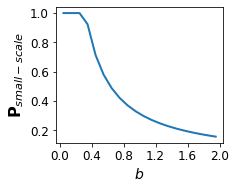

In [323]:
fig = plt.figure(figsize=(3,2.5))

# Probability over b
b_array = numpy.arange(0.05,2.02,0.1)
probabilities = [calculate_probability_extinction(p=p, B=b*numpy.array(B), I1_0=I1_0, I2_0=I2_0,N=1) for b in b_array]

plt.plot(b_array, probabilities, linewidth=2, label='$b$')

plt.xticks(numpy.arange(0.0,2.02,0.4),fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("$b$", fontsize=14)
plt.ylabel('$\mathbf{P}_{small-scale}$', fontsize=16)

b = 1                 # set b to previous value again

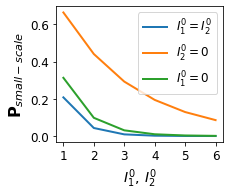

In [324]:
fig = plt.figure(figsize=(3,2.5))

# Probability over same I_0 value for I1_0 and I2_0
I_0_array = range(1,7)
probabilities = [calculate_probability_extinction(p=p, B=b*B, I1_0=I_0, I2_0=I_0) for I_0 in I_0_array]

plt.plot(I_0_array, probabilities, label='$I_1^0 = I_2^0$', linewidth=2)

I1_0 = 0              # set I_0 to previous value again
I2_1 = 1


# Probability over I1_0, with I2_0 = 0
I_0_array = range(1,7)
probabilities = [calculate_probability_extinction(p=p, B=b*B, I1_0=I_0, I2_0=0) for I_0 in I_0_array]

plt.plot(I_0_array, probabilities, label='$I_2^0=0$', linewidth=2)

I1_0 = 0              # set I_0 to previous value again
I2_0 = 1

# Probability over I2_0, with I1_0 = 0
I_0_array = range(1,7)
probabilities = [calculate_probability_extinction(p=p, B=b*B, I1_0=0, I2_0=I_0) for I_0 in I_0_array]

plt.plot(I_0_array, probabilities, label='$I_1^0=0$', linewidth=2)

plt.xticks(I_0_array,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size':12})
plt.xlabel('$I_1^0, \, I_2^0$', fontsize=14)
plt.ylabel('$\mathbf{P}_{small-scale}$', fontsize=16)

I1_0 = 0              # set I_0 to previous value again
I2_0 = 1

It is also interesting to study how the probability of extinction changes for different values of $B_{11}, B_{22}$. For simplicity, we suppose $B_{12}=B_{21}$.

Also, since a lot of numerical calculations would have to be performed in the following plots to calculate $\mathbf{P}_{small-scale}$, we will study the evolution of $\lambda$ instead (see the written report for the definition of $\lambda$). $\lambda$ denotes the mean growth rate of the infected population. Therefore, the largest $\lambda$ is, the lower the probability of the outbreak being contained and thus being small-scale (or, equivalently, the larger the probability of the outbreak being large-scale).

In [325]:
# Fix the parameters again
p = 0.1

b = 1
B = b*numpy.array([[0.3,0.5],
                      [0.5,1.1]])
I1_0 = 0
I2_0 = 1
N=1000

In [326]:
calculate_lambda(p=0.1, N=1000, B = [[0.3,0.5],[0.5,1.1]])

1.00001289163843

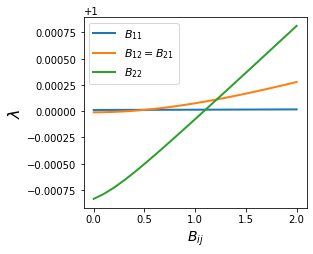

In [327]:
fig = plt.figure(figsize=(4,3.5))

# Probability over B[0][0]
b_array = numpy.arange(0.0,2.02,0.1)
probabilities = []
for a in b_array:
    B[0][0] = a
    probabilities.append(calculate_lambda(p=p, B=B, N=N))

plt.plot(b_array, probabilities, linewidth=2, label='$B_{11}$')

B = b*numpy.array([[0.3,0.5],   # set B to previous value again
                   [0.5,1.1]])


# Probability over B[0][1] = B[0][1]
b_array = numpy.arange(0.0,2.02,0.1)
probabilities = []
for a in b_array:
    B[0][1] = a
    B[1][0] = a
    probabilities.append(calculate_lambda(p=p, B=B,N=N))

plt.plot(b_array, probabilities, linewidth=2, label='$B_{12}=B_{21}$')

B = b*numpy.array([[0.3,0.5],   # set B to previous value again
                   [0.5,1.1]])


# Probability over B[0][0]
b_array = numpy.arange(0.0,2.02,0.1)
probabilities = []
for a in b_array:
    B[1][1] = a
    probabilities.append(calculate_lambda(p=p, B=B,N=N))

plt.plot(b_array, probabilities, linewidth=2, label='$B_{22}$')

B = b*numpy.array([[0.3,0.5],   # set B to previous value again
                   [0.5,1.1]])


plt.legend(prop={'size':11})
plt.xlabel("$B_{ij}$", fontsize=14)
plt.ylabel('$\lambda$', fontsize=16)

B = b*numpy.array([[0.3,0.5],   # set B to previous value again
                   [0.5,1.1]])

In [328]:
# !pip install plotly

In [329]:
from plotly.subplots import make_subplots

# Heatmap for B_11, B_22
TOL = 1e-5

p = 0.1
B = b*numpy.array([[0.3,0.5],   # set B to previous value again
                   [0.5,1.1]])

fig = make_subplots(rows=1, cols=3, subplot_titles=("$p=0.1$","$p=0.3$", "$p=0.5$"))

i=1
for p in [0.1,0.3,0.5]:
    
    b_array = numpy.arange(0.0,2.02,0.04)
    probabilities = []
    lambda_equals_1_x = []
    lambda_equals_1_y = []

    # Iterate through values for B[0][0]
    for b00 in b_array:
        probabilities_row = []
        B[0][0] = b00

        # Iterate through values for B[1][1]
        for b11 in b_array:
            B[1][1] = b11
            l = calculate_lambda(p=p, B=B,N=N)
            probabilities_row.append(l)
            if abs(l-1) < TOL:
                lambda_equals_1_x.append(b11)
                lambda_equals_1_y.append(b00)
                
        probabilities.append(probabilities_row)

        B = b*numpy.array([[0.3,0.5],   # set B to previous value again
                   [0.5,1.1]])

    # Plot
    probabilities = numpy.array(probabilities, dtype=numpy.float64)
    
    #fig = px.imshow(probabilities, x=b_array, y=b_array, title="$p={}$".format(p))
    fig.add_trace(
        go.Heatmap(z=probabilities, x=b_array, y=b_array, coloraxis = "coloraxis",), 
        1, i
    )
    fig.add_trace(
        go.Scatter(x= lambda_equals_1_x, y=lambda_equals_1_y,line =dict(color='lightblue',width=1), showlegend=False),
        1, i
    )
    
    i += 1
    
    
    
fig.update_layout(
    #xaxis_title="$B_{22}$", 
    #yaxis_title="$B_{11}$", 
    title_x=0.5,
    title_y=0.5,
    font_size=14,
)
    
fig.update_xaxes(title_text="$B_{22}$", row=1, col=2,)
fig.update_yaxes(title_text="$B_{11}$", row=1, col=1)

fig.update_layout(
    autosize=False,
    width = 1000, 
    height = 410,)

fig.layout.annotations[0].update(y=1.05)
fig.layout.annotations[1].update(y=1.05)
fig.layout.annotations[2].update(y=1.05)

fig.update_yaxes(autorange=True)
fig.update_xaxes(autorange=True,tickvals = numpy.arange(0,2.2,0.4))
    
    
fig.show()

#### Spread of the outbreak in the case of a lockdown  <a class="anchor" id="results-lockdown"></a>

In [330]:
TOL = 1e-5

p = 0.1    # non-fixed
N=1000
b22=1.1
B = numpy.array([[0,0],     # only b22 is fixed
                 [0,b22]])

b_array = numpy.arange(0.0,b22,0.005)
probabilities_array = numpy.arange(0.0, 1.01, 0.02)
lambdas = []
lambda_equals_1_x = []
lambda_equals_1_y = []

# Iterate through values for B[0][0]
for a in b_array:
    lambdas_row = []
    B[0][0] = a
    B[0][1] = a
    B[1][0] = a

    # Iterate through values for B[1][1]
    for p in probabilities_array:
        l = calculate_lambda(p=p, B=B, N=N)
        lambdas_row.append(l)
        if abs(l-1) < TOL:
            lambda_equals_1_x.append(p)
            lambda_equals_1_y.append(a)

    lambdas.append(lambdas_row)

    B = numpy.array([[0,0],     # only B[1][1] (that is B_22 in the model) is fixed
                     [0,b22]])

# Plot
lambdas = numpy.array(lambdas, dtype=numpy.float64)

fig = px.imshow(lambdas, x=probabilities_array, y=b_array, aspect=2)

fig.add_trace(
    go.Scatter(x= lambda_equals_1_x, y=lambda_equals_1_y,line =dict(color='lightblue',width=1), showlegend=False)
)

fig.update_layout(
    #xaxis_title="$B_{22}$", 
    #yaxis_title="$B_{11}$", 
    title_x=0.5,
    title_y=0.5,
    font_size=14,
)
    
fig.update_xaxes(title_text="$p$")
fig.update_yaxes(title_text="$B_{11} = B_{12} = B_{21}$")

fig.update_layout(
    autosize=False,
    width = 400, 
    height = 350,)

fig.update_yaxes(tickvals = numpy.arange(0.0,1.4,0.2),autorange=True)
fig.update_xaxes(tickvals = numpy.arange(0.0,1.01,0.2), autorange=True)

fig['layout']['yaxis']['scaleanchor']='y'

#fig['layout']['xaxis']['gridcolor'] = 'rgba(0, 0, 0, 0)'
#fig['layout']['yaxis']['gridcolor'] = 'rgba(0, 0, 0, 0)'
#fig['layout']['yaxis']['color'] = 'rgba(0, 0, 0, 0)'

fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

fig.show()


### Low-contact _versus_ high-contact _patient zero_ <a class="anchor" id="results-patient-zero"></a>

For simplicity (and to accentuate the differences in both situations), here we suppose half of the population being low-contact and half being high-contact.

First, we simulate a few outbreaks where the _patient zero_ is of type 1 (low-contact) and a few outbreaks where the _patient zero_ is of type 2 (high-contact), and plot the outbreaks to make a first observation.

In [331]:
simulations_patient_zero_1 = simulate_outbreak_BP(
    p=0.1, 
    B = [[0.7,1],
         [1,5]],
    N=1000, 
    initial_I1=1,
    initial_I2=0,
    num_simulations=100, 
    num_generations=3500
)

simulations_patient_zero_2 = simulate_outbreak_BP(
    p=0.1, 
    B = [[0.7,1],
         [1,5]],
    N=1000, 
    initial_I1=0,
    initial_I2=1,
    num_simulations=100, 
    num_generations=3500
)

In [332]:
%matplotlib inline

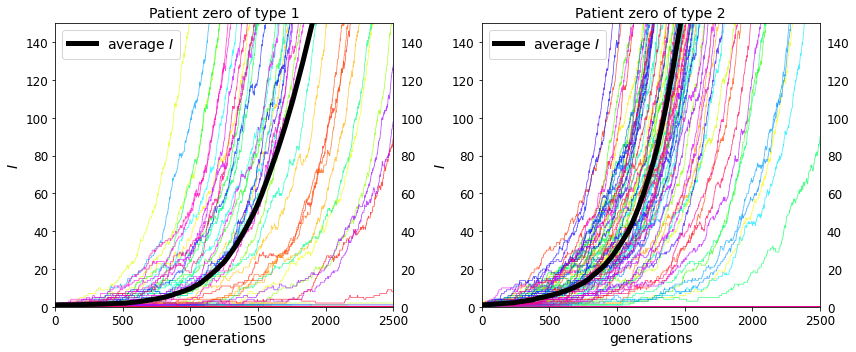

In [333]:
plt.figure(figsize=(12,5))
# (15,6)

plt.subplot(1,2,1)
plot_simulations_I(simulations_patient_zero_1, y_bound=150, x_bound=2500)
plt.title('Patient zero of type 1', fontsize=14)

plt.subplot(1,2,2)
plot_simulations_I(simulations_patient_zero_2, y_bound=150, x_bound=2500)
plt.title('Patient zero of type 2', fontsize=14)

plt.tight_layout()

Lines represent $I=I_1+I_2$. Lines of the same color correspond to the same outbreak simulation.

It seems that the outbreaks initiated by the high-contact individual tend to grow faster.

We now plot the number of extinguished simulations per time in both situations, to see how it differs. We will simulate a bigger number of outbreaks, and with more generations, to have a better view of the evolution of the outbreak.

In [334]:
more_simulations_patient_zero_1 = simulate_outbreak_BP(
    p=0.1, 
    B = [[0.7,1],
         [1,5]],
    N=1000, 
    initial_I1=1,
    initial_I2=0,
    num_simulations=1000, 
    num_generations=3500
)

analytical_probability_extinction_patient_zero_1 = calculate_probability_extinction(
    p=0.1, 
    B = [[0.7,1],
         [1,5]],
    I1_0=1,
    I2_0=0
)

In [335]:
more_simulations_patient_zero_2 = simulate_outbreak_BP(
    p=0.1, 
    B = [[0.7,1],
         [1,5]],
    N=1000, 
    initial_I1=0,
    initial_I2=1,
    num_simulations=1000, 
    num_generations=3500
)

analytical_probability_extinction_patient_zero_2 = calculate_probability_extinction(
    p=0.1, 
    B = [[0.7,1],
         [1,5]],
    I1_0=0,
    I2_0=1
)

In [336]:
# Run this to be able to interact with the plots below. For example, this will enable zooming 
# on the plot, to see a clearer view of the different phases of the spread (the initial phase
# is of our special interest)
%matplotlib notebook

In [337]:
# If you do not need to interact with the plots below, run this
%matplotlib inline

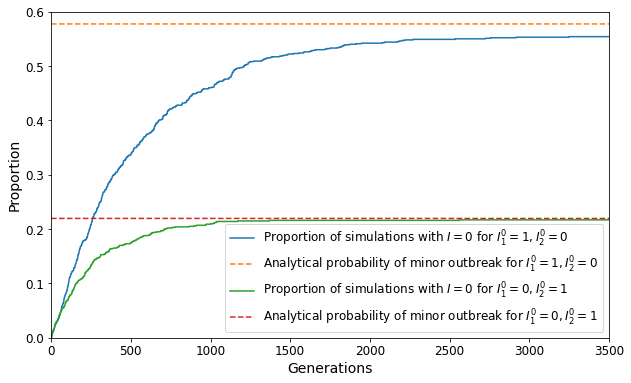

In [338]:
plt.figure(figsize=(10,6))

# Plot the number of extinguished simulations per time with patient zero being low-contact (type 1)
plot_extinguished_simulations_per_time(
    more_simulations_patient_zero_1,
    analytical_probability_extinction_patient_zero_1,
    label_proportion='Proportion of simulations with $I=0$ for $I_1^0 = 1, I_2^0=0$',
    label_probability='Analytical probability of minor outbreak for $I_1^0=1, I_2^0=0$', y_bound=0.6, x_bound=3500
)

# Plot the number of extinguished simulations per time with patient zero being high-contact (type 2)
plot_extinguished_simulations_per_time(
    more_simulations_patient_zero_2,
    analytical_probability_extinction_patient_zero_2,
    label_proportion='Proportion of simulations with $I=0$ for $I_1^0 = 0, I_2^0=1$',
    label_probability='Analytical probability of minor outbreak for $I_1^0=0, I_2^0=1$', y_bound=0.6, x_bound=3500
)

plt.show()

We observe that a larger proportion of simulated outbreaks achieve $I=0$ in the first phases of the spread if they are started by an individual with fewer contacts: a 45.8% of the outbreaks are extinguished by the generation 1000 in the situation simulated. In contrast, only 21.7% of the outbreaks initiated by an individual with many contacts are extinguished by the same generation.

In [339]:
extinguished_simulations_at_generation(more_simulations_patient_zero_1, 1000)

Number of infections extinguished at generation 1000: 460
	Proportion: 0.46


In [340]:
extinguished_simulations_at_generation(more_simulations_patient_zero_2, 1000)

Number of infections extinguished at generation 1000: 209
	Proportion: 0.209


This result observed in the simulations is supported by the fact that the probability of a minor-outbreak derived from the pgf is higher for the outbreak started by a low-contact patient than by a high-contact patient.

In [341]:
analytical_probability_extinction_patient_zero_1

0.5773800150584779

In [342]:
analytical_probability_extinction_patient_zero_2

0.21957980487353349

It is worth noticing that both outbreaks end up fully extinguished around more or less the same time points (this is due to the rest of the parameters being considered equal).

#### How long can low-contact individuals remain shielded after an outbreak begins among high-contact individuals? <a class="anchor" id="results-low-contact-shielded"></a>

One particular question we search to answer is: how long can low-contact individuals (type 1) remain unaffected by the infection after an outbreak begins among high-contact individuals (type 2)?

We will also see how this quantity depends on different parameters.

In [343]:
def first_position_that_differs_from_0(List):
        for i in range(len(List)):
            if List[i] != 0:
                return i

def calculate_generations_type1_shielded(simulations):
    
    generations_type1_shielded = []   
    # will store the generation up to which type 1 population remains shielded in every simulation
    
    for simulation in simulations:
        generation_until_infection = first_position_that_differs_from_0(simulation['I1'])
        if generation_until_infection is None:
            # if there is no infected population of type 1, we will consider the number of generations
            # used to simulate the outbreak
            generation_until_infection = len(simulation['I1'])
            
        generations_type1_shielded.append(generation_until_infection)
    
    mean_generation = sum(generations_type1_shielded)/len(generations_type1_shielded)
    return (min(generations_type1_shielded), mean_generation, max(generations_type1_shielded))

#calculate_generations_type1_shielded(simulations_patient_zero_2)

In [344]:
# Plot of mean generation up to which the type 1 remain shielded from an outbreak initiated by type 2,
# over different values of p and B_12 = B_21.

p_values = numpy.arange(0.00,1.01,0.02)
B12_B21_values = numpy.arange(0.00,1.2,0.03)
mean_generations_p = []

for b in B12_B21_values:
    mean_generations_row = []
    for p in p_values:
        simulations_for_shielded = simulate_outbreak_BP(
            p=p, 
            B=[[0.3, b],
               [b, 1.1]],
            N=1000, 
            initial_I1=0,
            initial_I2=1,
            num_simulations=100, 
            num_generations=200
        )
    
        mean_generations_row.append(calculate_generations_type1_shielded(simulations_for_shielded)[1])
    
    mean_generations_p.append(mean_generations_row)

In [345]:
# Plot
mean_generations_p = numpy.array(mean_generations_p, dtype=numpy.float64)

fig = go.Figure(data=go.Heatmap(z=mean_generations_p, x=p_values, y=B12_B21_values))

fig.update_layout(
    xaxis_title="$p$", 
    yaxis_title="$B_{21} = B_{12}$", 
    font_size=14,
)

fig.update_layout(
    autosize=False,
    width = 500, 
    height = 500,
    #yaxis_range=[0,5],
    #xaxis_range=[0,1]
)

fig.update_yaxes(autorange=True)


fig.show()

#### Simulating the case of a nursing home <a class="anchor" id="results-nursing-home"></a>

In [346]:
# Plot of mean generation up to which the type 1 remain shielded from an outbreak initiated by type 2.
# Case of isolated nursing home

p = 0.9
B11 = 1.1
B22 = 0.3

B12_B21_values = numpy.arange(0.00,2.02,0.1)
mean_generations_isolated = []

for b in B12_B21_values:
    simulations_isolated_nursing_home = simulate_outbreak_BP(
        p=p, 
        B=[[B11, b],
           [b, B22]],
        N=100, 
        initial_I1=0,
        initial_I2=1,
        num_simulations=1000, 
        num_generations=2000
    )
    
    mean_generations_isolated.append(calculate_generations_type1_shielded(simulations_isolated_nursing_home)[1])

Text(0, 0.5, 'Generations')

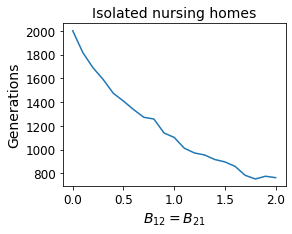

In [347]:
plt.figure(figsize=(4,3))
plt.plot(B12_B21_values, mean_generations_isolated)

plt.title("Isolated nursing homes", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("$B_{12}=B_{21}$", fontsize=14)
plt.ylabel('Generations', fontsize=14)

In [348]:
TOL=1e-4

B11_values = numpy.arange(0.00,1.515,0.03)
B12_B21_values = numpy.arange(0.00,1.515,0.03)
lambdas = []
lambda_equals_1_x = []
lambda_equals_1_y = []

N=100
p=0.9
B22=0.3

for b12 in B12_B21_values:
    lambdas_row = []
    for b11 in B11_values:
        l = calculate_lambda(
            p=p, 
            B=[[b11, b12],
               [b12, B22]],
            N=N)
        lambdas_row.append(l)
        if abs(l-1) < TOL:
            lambda_equals_1_x.append(b11)
            lambda_equals_1_y.append(b12)

    lambdas.append(lambdas_row)
        

In [349]:
# Plot
lambdas = numpy.array(lambdas, dtype=numpy.float64)

fig = px.imshow(lambdas, x=B11_values, y=B12_B21_values)

fig.add_trace(
    go.Scatter(x= lambda_equals_1_x, y=lambda_equals_1_y,line =dict(color='lightblue',width=1), showlegend=False)
)

fig.update_layout(
    xaxis_title="$B_{11}$", 
    yaxis_title="$B_{12}=B_{21}$", 
    font_size=14,
)

fig.update_layout(
    autosize=False,
    width = 400, 
    height = 350,
    #yaxis_range=[0,5],
    #xaxis_range=[0,1]
)

fig.update_yaxes(autorange=True)
fig.update_yaxes(autorange=True)
fig.update_xaxes(autorange=True,tickvals = numpy.arange(0,1.55,0.3))

fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')


fig.show()